In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# 1 Plot the pressure contour and the streamline

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [158]:
phi = 0.02
alpha = -0.001
eps = 0.01
Re = 1e-05
x_len = 110
z_len = 1
h_in = 1
h_end = 1+ alpha/eps
Z, X = np.mgrid[0:z_len:101j, 0:x_len:1001j]
# xx= np.linspace(0,x_len,100)
# zz = np.linspace(0,hh,100)
# Z, X = np.meshgrid(, xx)

In [159]:
Z = np.ma.masked_where(Z > 1+alpha*X, Z)
X = np.ma.masked_where(Z > 1+alpha*X, X)
h = 1 + alpha/eps*X/100

In [160]:
# Non-dimensional
dpdx = -3/(3*phi*h+h**2)
dpdx2 = (9*phi + 6*h)*alpha/eps/(3*phi*h+h**2)**2
p = (np.log(3*phi+h)-np.log(h))/(phi*alpha/eps)
p_range = np.max(p) - np.min(p)
p = (p - np.min(p))/p_range

In [162]:
v0 = (h + phi)*alpha/eps*dpdx*Z - ((Z**3/6-h**2*Z/2-phi*h*Z))*dpdx2
V = eps*v0 

In [163]:
u0 = -dpdx*(0.5*(h**2-Z**2)+phi*h)
u1 = ((0.5*h**2 + phi*h)**2*(Z**2-h**2)*0.5 + (Z**6-h**6)/360)*dpdx*dpdx2 
u1 += ((0.5*h**2 + phi*h)*(Z**2-h**2)*0.5 + (Z**4-h**4)/24)*(h+phi)*alpha/eps*dpdx**2
U = u0 + eps*Re*u1

In [165]:
# flow_u = flow.pivot(index='x', columns='z', values='u')
# flow_u.head(10)
Umag = np.sqrt(U**2 + V**2)

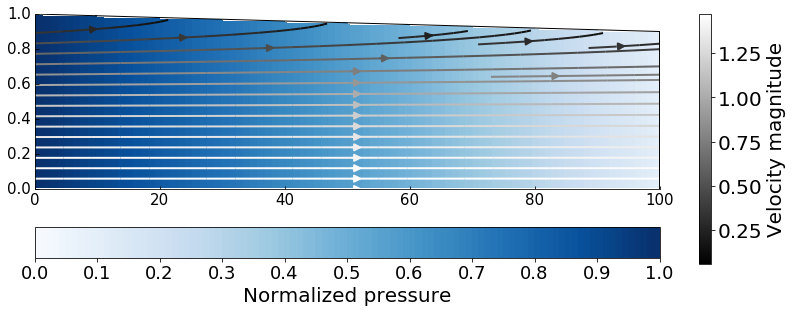

In [168]:
from mpl_toolkits.axisartist.axislines import SubplotZero
# https://matplotlib.org/3.1.1/gallery/axisartist/simple_axisline2.html
# #sphx-glr-gallery-axisartist-simple-axisline2-py
tickSize       = 18
labelFontSize  = 20
axis_font      = 15
fig = plt.figure(figsize=(14, 4.6))
ax1 = SubplotZero(fig, 1, 1, 1)
fig.add_subplot(ax1)
for n in ["top", "right"]:
    ax1.axis[n].set_visible(False)
    
plt.plot([0, 0, 100, 100],[0, h_in, h_end,0], color='k', linestyle='-', linewidth=1)


# fig, ax1 = plt.subplots(figsize=(14, 4.5), constrained_layout=True)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
ax1.set_adjustable(adjustable='datalim', share=False)

font = {'size': 15}

plt.rc('font', **font)

# Varying color along a streamline
strm = ax1.streamplot(X, Z, U, V, 
                      arrowsize=1.5, density=[0.8, 0.6], color=Umag, linewidth=2, cmap='gray')
# strm_tick = [0.5, 1.0, 1.5]
strm_bar = fig.colorbar(strm.lines)#,ticks=strm_tick)
strm_bar.set_label('Velocity magnitude',fontsize = labelFontSize)
strm_bar.ax.tick_params(labelsize=labelFontSize) 
ax1.set(ylim=(0, 1))
ax1.set(xlim=(0, 100))

con = ax1.contourf(X, Z, p, cmap="Blues",levels = 120)
p_tick = np.linspace(0, 1.0,11, endpoint=True)
p_bar = fig.colorbar(con,ticks=p_tick,orientation='horizontal')
p_bar.set_label('Normalized pressure',fontsize = labelFontSize)
p_bar.ax.tick_params(labelsize=tickSize) 
figure_folder = "./"
figure_name = "streamline.eps"
figure_file_path = figure_folder + figure_name
plt.savefig(figure_file_path)

In [139]:
p

masked_array(
  data=[[1.0, 0.9990980560113587, 0.998195934951626, ...,
         0.002217175064026662, 0.0011087081692917576, 0.0],
        [1.0, 0.9990980560113587, 0.998195934951626, ...,
         0.002217175064026662, 0.0011087081692917576, 0.0],
        [1.0, 0.9990980560113587, 0.998195934951626, ...,
         0.002217175064026662, 0.0011087081692917576, 0.0],
        ...,
        [1.0, 0.9990980560113587, 0.998195934951626, ..., --, --, --],
        [1.0, 0.9990980560113587, 0.998195934951626, ..., --, --, --],
        [1.0, --, --, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

# 2. Plot ux, uz profile at x = 50, phi = 0.00, 0.02, 0.04

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Define variables  
eps = 0.01
alpha = [0, -10**(-4), -5*10**(-4), -10**(-3)]
Re = [10**(-5), 10**(-4),10**(-3)]
phi = [0.0, 0.02, 0.04]

In [5]:
# load data: averaged value at different x location
def Avg_val(alpha_id,Re_id,phi_id):
    """
    Create a dataframe to store all relevant parameters: x-coordinate, pressure, dpdx, ux, conductivity, at the 
    latest saved time (when the simulation reaches convergence).
    """
    fileName = "geo"+str(alpha_id)+ "phi" + str(phi_id) + "Re"+ str(Re_id)+".dat"
    df = pd.read_csv("./codedFixedValue/dat/"+fileName, sep='\t', names=['Time','Coord','p','gradPx','gradPy',
                                                             'gradPz','Ux','Uy','Uz','volume'])

    Re_ = Re[Re_id]
    # slice the data at last time (converged)
    data_end = df.iloc[-1000:] 
    data_end = data_end[['Coord','gradPx', 'Ux','p']]
    data_end['gradPx'] = data_end['gradPx']*Re_ # Non-dimensionalization
    data_end['conductivity'] = -data_end['Ux']/data_end['gradPx']
    data_end = data_end.reset_index()
#     dp = data_end.iloc[-1]['p'] - data_end.iloc[0]['p']    
    u_norm = data_end.loc[data_end['Coord'] == 50.05]['Ux'].values # <u> at x = 50.05
    return data_end,u_norm

# Save the data in separate dataframe for all combinations of alpha, Re, phi. 
# We will use these dataframes for conductivity
for a_id in range(len(alpha)):
    for re_id in range(len(Re)):
        for phi_id in range(len(phi)):
            df_name = "df_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
            u_norm = "u_norm_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id) 
            exec('{0},{1} = Avg_val(a_id, re_id, phi_id)'.format(df_name, u_norm))

In [14]:
## save dataframe to csv files
for a_id in range(len(alpha)):
    for re_id in range(len(Re)):
        for phi_id in range(len(phi)):
            
            df_name = "df_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
            u_norm = "u_norm_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
            exec('{}.to_csv("./dataframe/{}.csv")'.format(df_name,df_name))

In [83]:
# load data: velocity field at the latest save time (when simulation converges) at x = 50
def flow(alpha_id,Re_id,phi_id):
    
    # simulation results
    fileName = "U_geo"+str(alpha_id)+ "phi" + str(phi_id) + "Re"+ str(Re_id)
    velocity = open('./codedFixedValue/vels/' + fileName)
    vel = velocity.readlines()
    ux = []
    uz = []
    grid = 20*2000
    vnum_list = ['0','1','2','3','4','5','6','7','8','9','.','-','e']
    for v in vel[22:(22+grid)]:
        i = 1
        ux_val = ''
        j = -3
        uz_val = ''
        while v[i] in vnum_list:
            ux_val += v[i]
            i += 1
        while v[j] in vnum_list:
            uz_val += v[j]
            j -= 1
        ux.append(float(ux_val))
        uz.append(float(uz_val[::-1]))

    x_node = 2000
    z_node = 20
    # add coordinates: 2000 in x, 20 in z
    ix = list(np.linspace(0,100,x_node))*z_node  # x-coordinate
    alpha_ = alpha[alpha_id]
    iz = [] # z-coordinate
    hend = 1 + alpha_ * 100
    h_in = np.linspace(0,1,z_node)
    h_end = np.linspace(0,hend,z_node)
    for i in range(z_node):
        iz += list(np.linspace(h_in[i],h_end[i],x_node))
    # create a data frame 
    flow = {'x_n':ix,'z':iz,'ux_s': ux,'uz_s':uz}
    df = pd.DataFrame(flow, columns=['x_n','z','ux_s','uz_s'])
    
    df_50 = df.loc[(df['x_n'] == 50.02501250625313)]
    
    phi_ = phi[phi_id]
    Re_ = Re[Re_id]
    
    # analytical solution
    df_50['x'] = df['x_n']*eps
    
    df_50['h'] = 1 +alpha_/eps*df_50['x']
    
    df_50['dpdx'] = -3/(3*phi_*df_50['h']  + df_50['h']**2)
    
    df_50['dpdx2'] = (9*phi_ + 6*df_50['h'])*alpha_/eps/(3*phi_*df_50['h']+df_50['h']**2)**2
    
    df_50['u0'] = -df_50['dpdx']*(0.5*(df_50['h']**2-df_50['z']**2)+phi_*df_50['h'])
    
    df_50['u1'] = ((0.5*df_50['h']**2 + phi_*df_50['h'])**2*(df_50['z']**2-df_50['h']**2)*0.5 \
                   + (df_50['z']**6-df_50['h']**6)/360)*df_50['dpdx']*df_50['dpdx2'] \
            + ((0.5*df_50['h']**2 + phi_*df_50['h'])*(df_50['z']**2-df_50['h']**2)*0.5 \
               + (df_50['z']**4-df_50['h']**4)/24)*(df_50['h']+phi_)*alpha_/eps*df_50['dpdx']**2
    
    df_50['ux_t'] = df_50['u0'] + eps*Re_*df_50['u1']
    
    df_50['uz_t'] = (df_50['h'] + phi_)*alpha_/eps*df_50['dpdx']*df_50['z'] \
            - ((df_50['z']**3/6 - df_50['h']**2*df_50['z']/2-phi_*df_50['h']*df_50['z']))*df_50['dpdx2']
    
    
    return df_50

# Save the data in separate dataframe for all combinations of alpha, Re, phi. (x = 50)
for a_id in range(len(alpha)):
    for re_id in range(len(Re)):
        for phi_id in range(len(phi)):
            df_name = "U_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
            exec('{} = flow(a_id, re_id, phi_id)'.format(df_name))

In [ ]:
## save dataframe to csv files

# for a_id in range(len(alpha)):
#     for re_id in range(len(Re)):
#         for phi_id in range(len(phi)):
            
#             df_name = "U_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
#             exec('{}.to_csv("./dataframe/{}.csv")'.format(df_name,df_name))

## 2.1 Plot velocity profile at x = 50

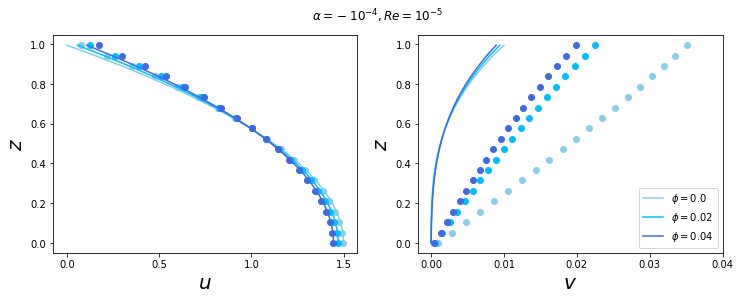

In [155]:
# Non-dimensional
%matplotlib inline

figwidth = 12
figheight = 4

fig,axes = plt.subplots(1,2, figsize=(figwidth,figheight))
ax1 = axes[0]
colors = ['skyblue','deepskyblue', 'royalblue']
ax2 = axes[1]

for phi_id in range(len(phi)):
    re_id = 0
    a_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors[phi_id]
    exec("ax1.plot(U{}['ux_s']/u_norm{},U{}['z'],'o', color = '{}')".format(name,name,name,color))
    exec("ax1.plot(U{}['ux_t'], U{}['z'],'-', color = '{}',label = r'$\phi = {}$')"\
         .format(name,name,color,phi[phi_id]))  #/np.mean(U{}['ux_t'])
    ax1.set_xlabel(r"$u$",fontsize = 20)
    ax1.set_ylabel(r"$z$",fontsize = 20)
    ax1.set_xticks(np.arange(0, 1.6, 0.5))
    
    exec("ax2.plot(U{}['uz_s']/u_norm{}/eps, U{}['z'], 'o', color = '{}')".format(name,name,name,color))
    exec("ax2.plot(U{}['uz_t'], U{}['z'], '-', color = '{}',label = r'$\phi = {}$')"\
         .format(name,name,color,phi[phi_id]))
    ax2.set_xlabel(r"$v$",fontsize = 20)
    ax2.set_ylabel(r"$z$",fontsize = 20) 
    ax2.set_xticks(np.arange(0, 0.041, 0.01))
    plt.suptitle(r"$\alpha = -10^{-4}, Re = 10^{-5}$")
    plt.legend();

In [543]:
# name =  "_a1re0phi1" 
np.mean(U_a1re0phi1['ux_t'])

0.9854272159154661

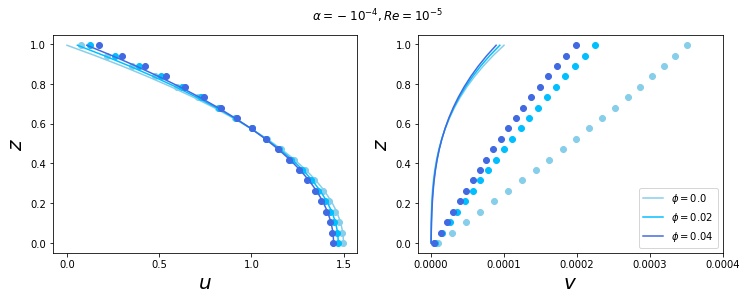

In [23]:
%matplotlib inline

# Dimensional

figwidth = 12
figheight = 4

fig,axes = plt.subplots(1,2, figsize=(figwidth,figheight))
ax1 = axes[0]
colors = ['skyblue','deepskyblue', 'royalblue']
ax2 = axes[1]

for phi_id in range(len(phi)):
    re_id = 0
    a_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors[phi_id]
    exec("ax1.plot(U{}['ux_s']/u_norm{},U{}['z'],'o', color = '{}')".format(name,name,name,color))
    exec("ax1.plot(U{}['ux_t'],U{}['z'],'-', color = '{}',label = r'$\phi = {}$')"\
         .format(name,name,color,phi[phi_id]))
    ax1.set_xlabel(r"$u$",fontsize = 20)
    ax1.set_ylabel(r"$z$",fontsize = 20)
    ax1.set_xticks(np.arange(0, 1.6, 0.5))
    
    exec("ax2.plot(U{}['uz_s']/u_norm{}, U{}['z'], 'o', color = '{}')".format(name,name,name,color))
    exec("ax2.plot(U{}['uz_t']*eps, U{}['z'], '-', color = '{}',label = r'$\phi = {}$')"\
         .format(name,name,color,phi[phi_id]))
    ax2.set_xlabel(r"$v$",fontsize = 20)
    ax2.set_ylabel(r"$z$",fontsize = 20)  
    ax2.set_xticks(np.arange(0, 0.00041, 0.0001))

    plt.suptitle(r"$\alpha = -10^{-4}, Re = 10^{-5}$")
    plt.legend();

Note that phi = 0.0 does not indicate no permeation.

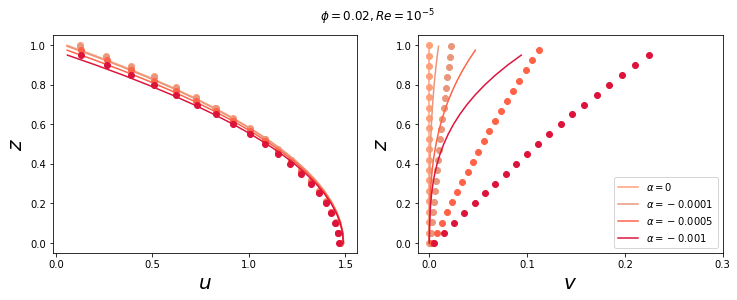

In [24]:
%matplotlib inline

figwidth = 12
figheight = 4

fig,axes = plt.subplots(1,2, figsize=(figwidth,figheight))
ax1 = axes[0]
colors = ['lightsalmon','darksalmon','tomato','crimson']
ax2 = axes[1]

for a_id in range(len(alpha)):
    re_id = 0
    phi_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors[a_id]
    exec("ax1.plot(U{}['ux_s']/u_norm{},U{}['z'],'o', color = '{}')".format(name,name,name,color))
    exec("ax1.plot(U{}['ux_t']/np.mean(U{}['ux_t']),U{}['z'],'-', color = '{}',label = r'$\phi = {}$')"\
         .format(name,name,name,color,phi[phi_id]))
    ax1.set_xlabel(r"$u$",fontsize = 20)
    ax1.set_ylabel(r"$z$",fontsize = 20)
    ax1.set_xticks(np.arange(0, 1.6, 0.5))
    
    exec("ax2.plot(U{}['uz_s']/u_norm{}/eps, U{}['z'], 'o', color = '{}')".format(name,name,name,color))
    exec('ax2.plot(U{}["uz_t"], U{}["z"], "-", color = "{}", label = r"$\\alpha = {}$")'\
         .format(name, name, color, alpha[a_id]))
    ax2.set_xlabel(r"$v$",fontsize = 20)
    ax2.set_ylabel(r"$z$",fontsize = 20) 
    ax2.set_xticks(np.arange(0, 0.31, 0.1))
    
    plt.suptitle(r"$\phi = 0.02, Re = 10^{-5}$")
    plt.legend()

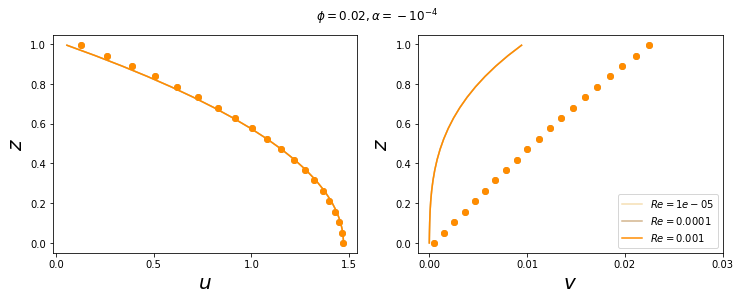

In [25]:
%matplotlib inline

figwidth = 12
figheight = 4

fig,axes = plt.subplots(1,2, figsize=(figwidth,figheight))
ax1 = axes[0]
colors = ['wheat','tan','darkorange']
ax2 = axes[1]

for re_id in range(len(Re)):
    a_id = 1
    phi_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors[re_id]
    exec("ax1.plot(U{}['ux_s']/u_norm{},U{}['z'],'o', color = '{}')".format(name,name,name,color))
    exec("ax1.plot(U{}['ux_t'],U{}['z'],'-', color = '{}',label = r'$\Re = {}$')"\
         .format(name,name,color,Re[re_id]))
    ax1.set_xlabel(r"$u$",fontsize = 20)
    ax1.set_ylabel(r"$z$",fontsize = 20)
    ax1.set_xticks(np.arange(0, 1.6, 0.5))
    
    exec("ax2.plot(U{}['uz_s']/u_norm{}/eps, U{}['z'], 'o', color = '{}')".format(name,name,name,color))
    exec('ax2.plot(U{}["uz_t"], U{}["z"], "-", color = "{}", label = r"$Re = {}$")'\
         .format(name, name, color, Re[re_id]))
    ax2.set_xlabel(r"$v$",fontsize = 20)
    ax2.set_ylabel(r"$z$",fontsize = 20)   
    ax2.set_xticks(np.arange(0, 0.031, 0.01))
    plt.suptitle(r"$\phi = 0.02, \alpha = -10^{-4}$")
    plt.legend()

# 3. Plot permeation velocity at the permeable wall

## 3.1 fixedFluxPressure BC

In [9]:
# load data: velocity at the latest save time (when simulation converges) at upper boundary
def flow_vw(alpha_id,Re_id,phi_id):
    
    # simulation results
    fileName = "U_geo"+str(alpha_id)+ "phi" + str(phi_id) + "Re"+ str(Re_id)
    velocity = open('./codedFixedValue/vels/' + fileName)
    vel = velocity.readlines()
    ux = []
    uz = []
    grid = 20*2000
    vnum_list = ['0','1','2','3','4','5','6','7','8','9','.','-','e']
    for v in vel[22:(22+grid)]:
        i = 1
        ux_val = ''
        j = -3
        uz_val = ''
        while v[i] in vnum_list:
            ux_val += v[i]
            i += 1
        while v[j] in vnum_list:
            uz_val += v[j]
            j -= 1
        ux.append(float(ux_val))
        uz.append(float(uz_val[::-1]))

    x_node = 2000
    z_node = 20
    # add coordinates: 2000 in x, 20 in z
    ix = list(np.linspace(0,100,x_node))*z_node  # x-coordinate
    alpha_ = alpha[alpha_id]
    iz = [] # z-coordinate
    hend = 1 + alpha_ * 100
    h_in = np.linspace(0,1,z_node)
    h_end = np.linspace(0,hend,z_node)
    for i in range(z_node):
        iz += list(np.linspace(h_in[i],h_end[i],x_node))
    # create a data frame 
    flow = {'x_n':ix,'z':iz,'ux_s': ux,'uz_s':uz}
    df = pd.DataFrame(flow, columns=['x_n','z','ux_s','uz_s'])
    
    df_upperWall = df.tail(x_node)
    
    phi_ = phi[phi_id]
    Re_ = Re[Re_id]
    delta = alpha_/eps
    # analytical solution
    
    df_upperWall['x'] = df['x_n']*eps    
    df_upperWall['h'] = 1 + delta*df_upperWall['x']
    df_upperWall['vw_t'] = - df_upperWall['h']/(3*phi_ + df_upperWall['h']) * delta  # Eq.(29)
    df_upperWall['vw_s'] = (df_upperWall['uz_s']/eps - df_upperWall['ux_s']*delta)/np.sqrt(1+delta**2) 
    # Non-dimensional
    return df_upperWall

# Save the data in separate dataframe for all combinations of alpha, Re, phi.
for a_id in range(len(alpha)):
    for re_id in range(len(Re)):
        for phi_id in range(len(phi)):
            df_name = "Vw_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
            exec('{} = flow_vw(a_id, re_id, phi_id)'.format(df_name))
#             exec({}.to_csv("./vwt/vwt_" + df_name + ".csv"))

In [10]:
Vw_a1re0phi1.head()

,x_n,z,ux_s,uz_s,x,h,vw_t,vw_s
38000,0.000000,1.000000,0.082091,0.055570,0.000000,1.000000,0.009434,5.557540
38001,0.050025,0.999995,0.083590,0.127669,0.000500,0.999995,0.009434,12.767056
38002,0.100050,0.999990,0.087233,0.173472,0.001001,0.999990,0.009434,17.347231
38003,0.150075,0.999985,0.090186,0.203171,0.001501,0.999985,0.009434,20.316983
38004,0.200100,0.999980,0.092236,0.221933,0.002001,0.999980,0.009434,22.193112


## Theory (Eq.29) vs. simulation (uz_s)

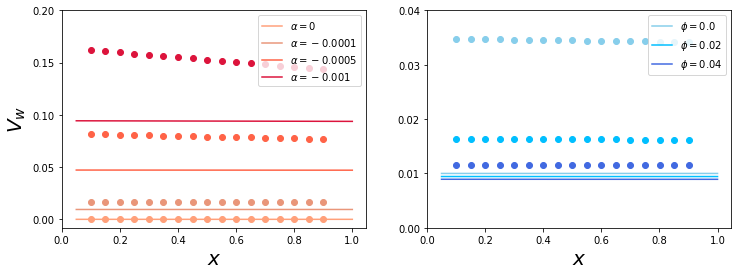

In [11]:

%matplotlib inline

figwidth = 12
figheight = 4

fig,axes = plt.subplots(1,2, figsize=(figwidth,figheight))
ax1 = axes[0]
colors_a = ['lightsalmon','darksalmon','tomato','crimson']
ax2 = axes[1]
colors_phi = ['skyblue','deepskyblue', 'royalblue']

for a_id in range(len(alpha)):
    re_id = 0
    phi_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors_a[a_id]
    exec("ax1.plot(Vw{}['x'][200:-100:100],Vw{}['uz_s'][200:-100:100]/eps,'o', color = '{}')"\
         .format(name,name,color))
    exec("ax1.plot(Vw{}['x'][100:],Vw{}['vw_t'][100:],'-', color = '{}',label = r'$\\alpha = {}$')"\
         .format(name,name,color,alpha[a_id]))
    ax1.set_xlabel(r"$x$",fontsize = 20)
    ax1.set_ylabel(r"$V_w$",fontsize = 20)
    
    ax1.legend()
    
    ax1.set_xticks(np.arange(0, 1.1, 0.2))
    ax1.set_yticks(np.arange(0, 0.21, 0.05))

for phi_id in range(len(phi)):
    re_id = 0
    a_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors_phi[phi_id]    
    
    exec("ax2.plot(Vw{}['x'][200:-100:100],Vw{}['uz_s'][200:-100:100]/eps,'o', color = '{}')"\
         .format(name,name,color))
    exec("ax2.plot(Vw{}['x'][100:],Vw{}['vw_t'][100:],'-', color = '{}',label = r'$\phi = {}$')"\
         .format(name,name,color,phi[phi_id]))
    ax2.set_xlabel(r"$x$",fontsize = 20)
#     ax2.set_ylabel(r"$V_w$",fontsize = 20)   
    ax2.set_xticks(np.arange(0, 1.1, 0.2))
    ax2.set_yticks(np.arange(0, 0.041, 0.01))
#     plt.suptitle(r"$\phi = 0.02, \alpha = -10^{-4}$")
    ax2.legend()

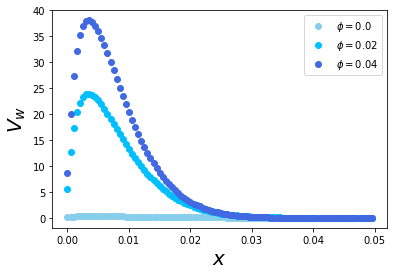

In [60]:
# The development of permeation velocity
for phi_id in range(len(phi)):
    re_id = 0
    a_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors_phi[phi_id]    
    
    exec("plt.plot(Vw{}['x'][:100],Vw{}['uz_s'][:100]/eps,'o', color = '{}',label = r'$\phi = {}$')"\
         .format(name,name,color,phi[phi_id]))
    plt.xlabel(r"$x$",fontsize = 20)
    plt.ylabel(r"$V_w$",fontsize = 20)   
#     ax2.set_xticks(np.arange(0, 1.1, 0.2))
#     ax2.set_yticks(np.arange(0, 0.041, 0.01))
#     plt.suptitle(r"$\phi = 0.02, \alpha = -10^{-4}$")
    plt.legend()

##  Theory (Eq. 29) vs. simulation (vw)

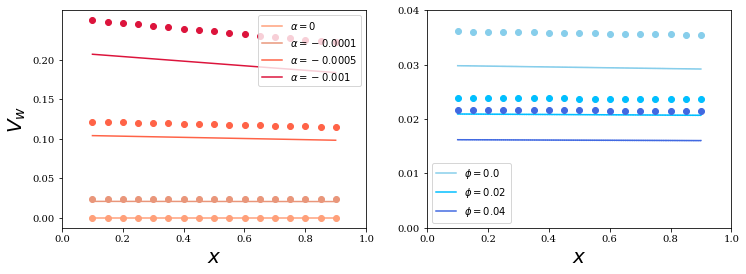

In [189]:
%matplotlib inline
figwidth = 12
figheight = 4
fig,axes = plt.subplots(1,2, figsize=(figwidth,figheight))
ax1 = axes[0]
colors_a = ['lightsalmon','darksalmon','tomato','crimson']
ax2 = axes[1]
colors_phi = ['skyblue','deepskyblue', 'royalblue']

for a_id in range(len(alpha)):
    re_id = 0
    phi_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors_a[a_id]
    exec("ax1.plot(Vw{}['x'][200:-100:100],Vw{}['vw_s'][200:-100:100]/u_norm{},'o', color = '{}')"\
         .format(name,name,name,color))
    
    fileName = "geo" + str(a_id) + "phi" + str(phi_id) + "Re" + str(re_id)     
    df_ = pd.read_csv("./vwt/vwt_" + fileName + ".csv")
    exec("ax1.plot(df_['Coord'][100:-100]*eps,df_['vw'][100:-100],'-', color = '{}',label = r'$\\alpha = {}$')"\
         .format(color,alpha[a_id]))
    
    ax1.set_xlabel(r"$x$",fontsize = 20)
    ax1.set_ylabel(r"$V_w$",fontsize = 20)
    
    ax1.legend()
    
    ax1.set_xticks(np.arange(0, 1.1, 0.2))
    ax1.set_yticks(np.arange(0, 0.21, 0.05))


for phi_id in range(len(phi)):
    re_id = 0
    a_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors_phi[phi_id]    
    fileName = "geo" + str(a_id) + "phi" + str(phi_id) + "Re" + str(re_id)     
    df_ = pd.read_csv("./vwt/vwt_" + fileName + ".csv")
    exec("ax2.plot(Vw{}['x'][200:-100:100],Vw{}['vw_s'][200:-100:100]/u_norm{},'o', color = '{}')"\
         .format(name,name,name,color))
    exec("ax2.plot(df_['Coord'][100:-100]*eps, df_['vw'][100:-100],'-', color = '{}',label = r'$\phi = {}$')"\
         .format(color,phi[phi_id]))
    ax2.set_xlabel(r"$x$",fontsize = 20)
#     ax2.set_ylabel(r"$V_w$",fontsize = 20)   
    ax2.set_xticks(np.arange(0, 1.1, 0.2))
    ax2.set_yticks(np.arange(0, 0.041, 0.01))
#     ax2.set_ylim([0,0.2])
#     plt.suptitle(r"$\phi = 0.02, \alpha = -10^{-4}$")
    ax2.legend()

## Theory (Eq. 13) vs. simulation (vw)

Plug numerical pressure gradient into analytical solution of v from Eq.(13)

In [330]:
# vw from theory (Eq.13)
for a_id in range(len(alpha)):
    for re_id in range(len(Re)):
        for phi_id in range(len(phi)):

            fileName = "geo" + str(a_id) + "phi" + str(phi_id) + "Re" + str(re_id) 
            df_ = pd.read_csv("./codedFixedValue/dat/"+fileName + ".dat" , sep='\t', 
                              names=['Time','Coord','p','gradPx','gradPy','gradPz','Ux','Uy','Uz','volume'])
            df_ = df_[-1000:]
            df_ = df_.drop(['p','gradPy','gradPz','Uy','Uz','volume'],axis = 1)
            
            df_['Coord'] *= eps
            df_['dpdx'] = df_['gradPx'] * Re[re_id]
            df_['dpdx2'] = df_['dpdx'].diff()/0.1 
            alpha_ = alpha[a_id]
            delta = alpha_/eps
            df_['h'] = 1 + delta * df_['Coord']            
            phi_ = phi[phi_id]
            df_['u'] = - phi_*df_['h']*df_['dpdx']
            # Eq.(13)
            df_['v'] = (df_['h'] + phi_) * delta * df_['h'] * df_['dpdx'] +\
                        ( df_['h']**3/3 + phi_ * df_['h']**2)*df_['dpdx2']
            
            # Calculate permeation velocity v_w from u and v
            df_['vw'] = (df_['v'] - df_['u']*delta)/np.sqrt(1+delta**2) 
            
            df_.to_csv("./vwt/vwt2_" +fileName+".csv")

In [321]:
from matplotlib import rc
rc('text', usetex=True)
# This makes the text in the figure vague... Trying to fix it.

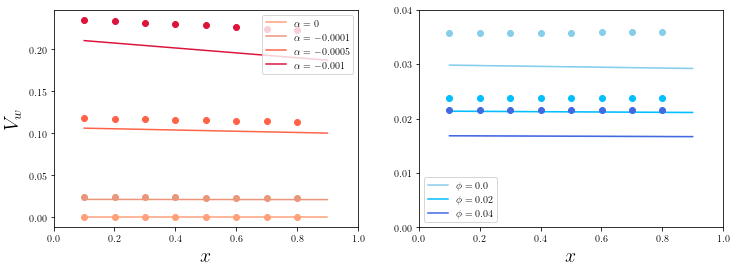

In [339]:
%matplotlib inline

figwidth = 12
figheight = 4
fig,axes = plt.subplots(1,2, figsize=(figwidth,figheight))
ax1 = axes[0]
colors_a = ['lightsalmon','darksalmon','tomato','crimson']
ax2 = axes[1]
colors_phi = ['skyblue','deepskyblue', 'royalblue']

for a_id in range(len(alpha)):
    re_id = 0
    phi_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors_a[a_id]
    exec("ax1.plot(Vw{}['x'][200:-200:200],Vw{}['vw_s'][200:-200:200]/df_['Ux'][100:-100:100].values,'o', \
         color = '{}')".format(name,name,color))
    
    fileName = "geo" + str(a_id) + "phi" + str(phi_id) + "Re" + str(re_id)     
    df_ = pd.read_csv("./vwt/vwt2_" + fileName + ".csv")
    exec("ax1.plot(df_['Coord'][100:-100],df_['vw'][100:-100],'-', color = '{}',label = r'$\\alpha = {}$')"\
         .format(color,alpha[a_id]))
    
    ax1.set_xlabel(r"$x$",fontsize = 20)
    ax1.set_ylabel(r"$V_w$",fontsize = 20)
#     ax1.set_ylim([-0.05,0.35])
    ax1.legend()
    
    ax1.set_xticks(np.arange(0, 1.1, 0.2))
#     ax1.set_yticks(np.arange(0, 0.31, 0.1))


for phi_id in range(len(phi)):
    re_id = 0
    a_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors_phi[phi_id]    
    fileName = "geo" + str(a_id) + "phi" + str(phi_id) + "Re" + str(re_id)     
    df_ = pd.read_csv("./vwt/vwt2_" + fileName + ".csv")
#     print(df_['Ux'][100:-100:100])
#     exec("print(Vw{}['x'][200:-200:200])".format(name))
    exec("ax2.plot(Vw{}['x'][200:-200:200],Vw{}['vw_s'][200:-200:200]/df_['Ux'][100:-100:100].values,'o', \
    color = '{}')".format(name,name,color))
    exec("ax2.plot(df_['Coord'][100:-100],df_['vw'][100:-100],'-', color = '{}',label = r'$\phi = {}$')"\
         .format(color,phi[phi_id]))
    ax2.set_xlabel(r"$x$",fontsize = 20)
#     ax2.set_ylabel(r"$V_w$",fontsize = 20)   
    ax2.set_xticks(np.arange(0, 1.1, 0.2))
    ax2.set_yticks(np.arange(0, 0.041, 0.01))
#     ax2.set_ylim([-0.05,0.35])
#     plt.suptitle(r"$\phi = 0.02, \alpha = -10^{-4}$")
    ax2.legend()
    

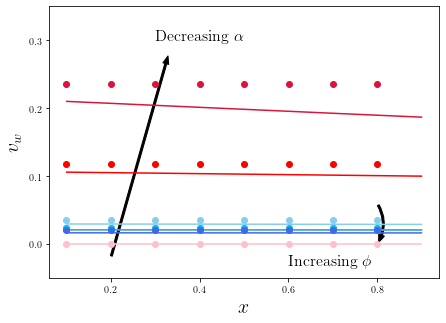

In [341]:
# Put the above two plots together
import matplotlib.patches as patches

%matplotlib inline
figwidth       = 7
figheight      = 5
lineWidth      = 2
textFontSize   = 15
gcafontSize    = 10
markerSize     = 4
labelFontSize  = 18
tickSize       = 12
figure_folder = "./"
fig = plt.figure(1, figsize=(figwidth,figheight))
fig.tight_layout()
figure_name = "permeationVelocity.eps"
figure_file_path = figure_folder + figure_name
ax = plt.gca()

# colors_a = ['lightsalmon','darksalmon','tomato','crimson']
colors_a = ['pink','salmon','red','crimson']
colors_phi = ['skyblue','deepskyblue', 'royalblue']
# colors_phi = ['lightsalmon','salmon', 'darksalmon']

for a_id in range(len(alpha)):
    re_id = 0
    phi_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
        
    fileName = "geo" + str(a_id) + "phi" + str(phi_id) + "Re" + str(re_id)     
    df_ = pd.read_csv("./vwt/vwt2_" + fileName + ".csv")
    color = colors_a[a_id]
    exec("ax.plot(Vw{}['x'][200:-200:200],Vw{}['vw_s'][200:-200:200]/df_['Ux'][100:-100:100].values,'o', \
    color = '{}')".format(name,name,color))

    exec("ax.plot(df_['Coord'][100:-100],df_['vw'][100:-100],'-', color = '{}',label = r'$\\alpha = {}$')"\
         .format(color,alpha[a_id]))
    
    ax.set_xlabel(r"$x$",fontsize = 20)
    ax.set_ylabel(r"$v_w$",fontsize = 20)
    ax.set_ylim([-0.05,0.35])
#     ax.legend()
    
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_yticks(np.arange(0, 0.31, 0.1))


for phi_id in range(len(phi)):
    re_id = 0
    a_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    color = colors_phi[phi_id]    
    fileName = "geo" + str(a_id) + "phi" + str(phi_id) + "Re" + str(re_id)     
    df_ = pd.read_csv("./vwt/vwt2_" + fileName + ".csv")
    exec("ax.plot(Vw{}['x'][200:-200:200],Vw{}['vw_s'][200:-200:200]/df_['Ux'][100:-100:100].values,'o', \
    color = '{}')".format(name,name,color))
    exec("ax.plot(df_['Coord'][100:-100],df_['vw'][100:-100],'-', color = '{}',label = r'$\phi = {}$')"\
         .format(color,phi[phi_id]))

# classic 
## Add arrow
style="Simple,tail_width=2,head_width=6,head_length=8"
kw1 = dict(arrowstyle=style, linestyle = "-", color="k")
kw2 = dict(arrowstyle=style, color="k")
a1 = patches.FancyArrowPatch((0.2,-0.02), (0.33,0.28),**kw1)
a2 = patches.FancyArrowPatch((0.8,0.06), (0.8,0),connectionstyle="arc3,rad=-.3", **kw2)
for a in [a1,a2]:
    plt.gca().add_patch(a)

## Add text box 
font = {'family': 'serif',
        'color':  'k',
        'weight': 'bold',
        'size': 16,
        }
plt.text(0.3, 0.3,r'Decreasing $\alpha$',  fontdict=font)
plt.text(0.6, -0.03,  r'Increasing $\phi$',fontdict=font);
plt.savefig(figure_file_path)


### Error percentage of permeation velocity

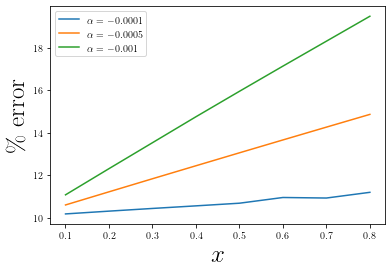

In [342]:
%matplotlib inline

import matplotlib.ticker as mtick

fig, ax = plt.subplots()
font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 25,
        }
for a_id in range(len(alpha)-1):
    a_id += 1
    re_id = 0
    phi_id = 1
    name = "_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)
    fileName = "geo" + str(a_id) + "phi" + str(phi_id) + "Re" + str(re_id)     
    df_ = pd.read_csv("./vwt/vwt2_" + fileName + ".csv")
    color = colors_a[a_id]
    exec("error = (Vw{}['vw_s'][200:-200:200].values/df_['Ux'][100:-100:100].values-df_['vw'][100:-100:100])\
    /(Vw{}['vw_s'][200:-200:200].values/df_['Ux'][100:-100:100].values)".format(name,name,name))
#     print(len(error))
    exec("ax.plot(Vw{}['x'][200:-200:200] , error, label=r'$\\alpha = {}$')".format(name,alpha[a_id]))
    
#     ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    
    ax.set_xlabel("$x$",fontdict=font)
    ax.set_ylabel("$\%$ error",fontdict=font)
    ax.legend()
#     ax.set_ylim([0,0.2])


## 3.2 zeroGradient BC for pressure

In [72]:
velocity = open('./codedFixedValue/vels/' + "U_zg")
vel = velocity.readlines()
ux = []
uz = []
grid = 20*2000
vnum_list = ['0','1','2','3','4','5','6','7','8','9','.','-','e']
for v in vel[22:(22+grid)]:
    i = 1
    ux_val = ''
    j = -3
    uz_val = ''
    while v[i] in vnum_list:
        ux_val += v[i]
        i += 1
    while v[j] in vnum_list:
        uz_val += v[j]
        j -= 1
    ux.append(float(ux_val))
    uz.append(float(uz_val[::-1]))

x_node = 2000
z_node = 20
# add coordinates: 2000 in x, 20 in z
ix = list(np.linspace(0,100,x_node))*z_node  # x-coordinate
alpha_ = -0.0005
iz = [] # z-coordinate
hend = 1 + alpha_ * 100
h_in = np.linspace(0,1,z_node)
h_end = np.linspace(0,hend,z_node)
for i in range(z_node):
    iz += list(np.linspace(h_in[i],h_end[i],x_node))
# create a data frame 
flow = {'x_n':ix,'z':iz,'ux_s': ux,'uz_s':uz}
df = pd.DataFrame(flow, columns=['x_n','z','ux_s','uz_s'])

df_upperWall = df.tail(x_node)

phi_ = 0.02
Re_ = 10**(-5)
delta = alpha_/eps
# analytical solution

df_upperWall['x'] = df['x_n']*eps    
df_upperWall['h'] = 1 + alpha_/eps*df_upperWall['x']
df_upperWall['vw_s'] = (df_upperWall['uz_s']/eps - df_upperWall['ux_s']*delta)/np.sqrt(1+delta**2) 

In [90]:
# load data: velocity at the latest save time (when simulation converges) at x = 50
def read_vel(filename):
    velocity = open('./codedFixedValue/vels/' + filename)
    vel = velocity.readlines()
    ux = []
    uz = []
    grid = 20*2000
    vnum_list = ['0','1','2','3','4','5','6','7','8','9','.','-','e']
    for v in vel[22:(22+grid)]:
        i = 1
        ux_val = ''
        j = -3
        uz_val = ''
        while v[i] in vnum_list:
            ux_val += v[i]
            i += 1
        while v[j] in vnum_list:
            uz_val += v[j]
            j -= 1
        ux.append(float(ux_val))
        uz.append(float(uz_val[::-1]))

    x_node = 2000
    z_node = 20
    # add coordinates: 2000 in x, 20 in z
    ix = list(np.linspace(0,100,x_node))*z_node  # x-coordinate
    alpha_ = -0.0005
    iz = [] # z-coordinate
    hend = 1 + alpha_ * 100
    h_in = np.linspace(0,1,z_node)
    h_end = np.linspace(0,hend,z_node)
    for i in range(z_node):
        iz += list(np.linspace(h_in[i],h_end[i],x_node))
    # create a data frame 
    flow = {'x_n':ix,'z':iz,'ux_s': ux,'uz_s':uz}
    df = pd.DataFrame(flow, columns=['x_n','z','ux_s','uz_s'])

    df_50 = df.loc[(df['x_n'] == 50.02501250625313)]

    phi_ = 0.02
    Re_ = 10**(-5)

    # analytical solution
    df_50['x'] = df['x_n']*eps

    df_50['h'] = 1 +alpha_/eps*df_50['x']

    df_50['dpdx'] = -3/(3*phi_*df_50['h']  + df_50['h']**2)

    df_50['dpdx2'] = (9*phi_ + 6*df_50['h'])*alpha_/eps/(3*phi_*df_50['h']+df_50['h']**2)**2

    df_50['u0'] = -df_50['dpdx']*(0.5*(df_50['h']**2-df_50['z']**2)+phi_*df_50['h'])

    df_50['u1'] = ((0.5*df_50['h']**2 + phi_*df_50['h'])**2*(df_50['z']**2-df_50['h']**2)*0.5 \
                   + (df_50['z']**6-df_50['h']**6)/360)*df_50['dpdx']*df_50['dpdx2'] \
            + ((0.5*df_50['h']**2 + phi_*df_50['h'])*(df_50['z']**2-df_50['h']**2)*0.5 \
               + (df_50['z']**4-df_50['h']**4)/24)*(df_50['h']+phi_)*alpha_/eps*df_50['dpdx']**2

    df_50['ux_t'] = df_50['u0'] + eps*Re_*df_50['u1']

    df_50['uz_t'] = (df_50['h'] + phi_)*alpha_/eps*df_50['dpdx']*df_50['z'] \
            - ((df_50['z']**3/6 - df_50['h']**2*df_50['z']/2-phi_*df_50['h']*df_50['z']))*df_50['dpdx2']


### Plot the vertical velocity profile at x = 50

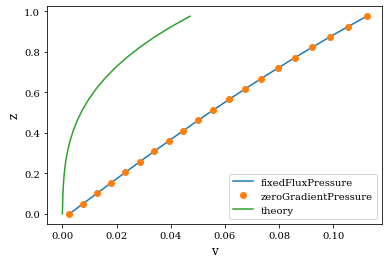

In [182]:
fig,ax = plt.subplots()
ax.plot(U_a2re0phi1['uz_s']/u_norm_a2re0phi1/eps, U_a2re0phi1['z'],label="fixedFluxPressure")
ax.plot(df_50['uz_s']/u_norm_a2re0phi1/eps,  df_50['z'], 'o',label = "zeroGradientPressure")
ax.plot(U_a2re0phi1["uz_t"], U_a2re0phi1["z"], "-",label="theory")
# plt.plot(df_50["uz_t"], df_50["z"], "-")
ax.set_xlabel("v",fontsize = 12)
ax.set_ylabel("z",fontsize = 12)
ax.legend()

In [91]:
vel1 = read_vel("U_zg") # velocity field using zeroGradient BC
vel2 = read_vel("U_geo2phi1Re0") # velocity field using fixedFluxPressure BC

In [92]:
vel1 == vel2

True

The velocities are exactly the same!!

# 4. Conductivity comparison

In [271]:
## Non-dimensional
def THEO_coeff(alpha,Re,phi):
    
    c1 = (3*phi+1)/3
    c2 = (3+22*phi+28*phi**2)/(35*(3*phi+1)**2)
    xnew = np.arange(0,100,0.5)
    n = np.size(xnew)
    slop_t = []
    dpdx = []
    u = []
    
    for i in range(n):

        slop = c1 + (2.0/3.0*xnew[i]/100 + phi*xnew[i]/100 - c2*Re*eps)*alpha/eps 
        slop_t.append(slop)
        uslip_t = 3*phi/(3*phi+1+alpha*xnew)  
        h = 1 + alpha*xnew[i]
        dpdx.append(-3/(3*phi*h+h**2))
        u.append(-(3*phi*h+h**2)/3*dpdx[i])

    return slop_t#,dpdx,u

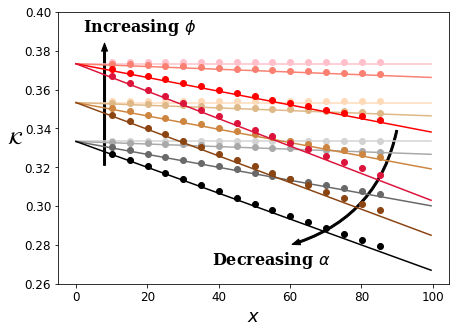

In [16]:
import matplotlib.patches as patches
%matplotlib inline
figwidth       = 7
figheight      = 5
lineWidth      = 2
textFontSize   = 15
gcafontSize    = 10
markerSize     = 4
labelFontSize  = 18
tickSize       = 12
figure_folder = "./"

fig = plt.figure(1, figsize=(figwidth,figheight))
fig.tight_layout()
figure_name = "conductivity.eps"
figure_file_path = figure_folder + figure_name


xnew = np.arange(0,100,0.5)
colors = [['lightgrey','darkgrey','dimgray','black'],
          ['peachpuff', 'burlywood','peru','saddlebrown'], 
          ['pink','salmon','red','crimson']]
#           ['skyblue','deepskyblue','dodgerblue','royalblue']]
# ['silver','darkgrey','dimgray','black']
# ['darkkhaki','y','olive','darkolivegreen']
#           ['thistle','violet','purple']]
# ['bisque','wheat','orange','darkorange'],
# ['coral','tomato','orangered','red']

for phi_id in range(len(phi)):
    for a_id in range(len(alpha)):    
        re_id = 0
        color = colors[phi_id][a_id]
        name = "df_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)    
        exec("plt.plot(df_a0re0phi1['Coord'][100:-100:50], {}['conductivity'][100:-100:50],'o',color = '{}')"\
             .format(name,color))
        exec("plt.plot(xnew, THEO_coeff(alpha[{}],Re[{}],phi[{}]),color = '{}')"\
             .format(a_id, re_id,phi_id,color))

# classic 
## Add arrow
style="Simple,tail_width=2,head_width=6,head_length=8"
kw1 = dict(arrowstyle=style, linestyle = "-", color="k")
kw2 = dict(arrowstyle=style, color="k")
a1 = patches.FancyArrowPatch((8,0.32), (8,0.385),**kw1)
a2 = patches.FancyArrowPatch((90,0.34), (60,0.28),connectionstyle="arc3,rad=-.3", **kw2)
for a in [a1,a2]:
    plt.gca().add_patch(a)

plt.xlabel(r"$x$",fontsize=labelFontSize)
plt.ylabel(r"$\mathcal{K}$",fontsize=labelFontSize,rotation=0)
# plt.legend(loc=3, fontsize = gcafontSize,facecolor = 'whitesmoke')
ax = plt.gca()
# ax.xaxis.set_ticks(np.arange(0,21,5))
ax.yaxis.set_ticks(np.arange(0.26,0.405,0.02))
ax.tick_params(axis='both', which='major', labelsize=tickSize)
ax.yaxis.set_label_coords(-0.11,0.5)

## Add text box 
font = {'family': 'serif',
        'color':  'k',
        'weight': 'bold',
        'size': 16,
        }
plt.text(2, 0.39, r'Increasing $\phi$', fontdict=font)
plt.text(38, 0.27, r'Decreasing $\alpha$', fontdict=font);

plt.savefig(figure_file_path)


# scatter plot: verification

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


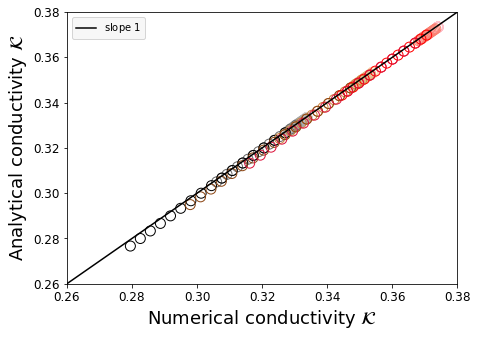

In [34]:
%matplotlib inline

figwidth       = 7
figheight      = 5
lineWidth      = 2
textFontSize   = 15
gcafontSize    = 10
markerSize     = 4
labelFontSize  = 18
tickSize       = 12

figure_folder = "./"
colors = [['lightgrey','darkgrey','dimgray','black'],
          ['peachpuff', 'burlywood','peru','saddlebrown'], 
          ['pink','salmon','red','crimson']]

fig = plt.figure(1, figsize=(figwidth,figheight))
ax = fig.add_subplot(1, 1, 1)
for phi_id in range(len(phi)):
    for a_id in range(len(alpha)):    
        re_id = 0
        color = colors[phi_id][a_id]
        name = "df_a" + str(a_id) + "re" + str(re_id) + "phi" + str(phi_id)  
        exec("x = {}['conductivity'][100:-100:50].values".format(name))
        exec("y = THEO_coeff(alpha[{}],Re[{}],phi[{}])[20:-20:10]".format(a_id, re_id,phi_id))
        plt.scatter(x, y, color = colors[phi_id][a_id], marker = 'o', facecolors='none', s=100);

# fig.tight_layout()
figure_name = "N_vs_S.eps"
figure_file_path = figure_folder + figure_name

xline = np.arange(0.26,0.385,0.01)
yline = xline
plt.plot(xline,yline, color = 'k',label = r"slope $1$")

plt.xlabel(r"Numerical conductivity $\mathcal{K}$",fontsize=labelFontSize)
plt.ylabel(r"Analytical conductivity $\mathcal{K}$",fontsize=labelFontSize)
ax.tick_params(axis='both', which='major', labelsize=tickSize)
ax.yaxis.set_ticks(np.arange(0.26,0.385,0.02))
ax.xaxis.set_ticks(np.arange(0.26,0.385,0.02))
plt.ylim(0.26, 0.38)
plt.xlim(0.26, 0.38)
plt.legend(loc=2, fontsize=gcafontSize,facecolor = 'whitesmoke')
plt.savefig(figure_file_path);
